In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
#load in the test adn train CSVs
test_data = pd.read_csv("/Users/xavier/Desktop/DSPP/DS/DirWk2/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")
train_data = pd.read_csv("/Users/xavier/Desktop/DSPP/DS/DirWk2/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")

In [3]:
#eliminate missing values
# Drop rpws where the outcome is NA or the home is not sold
train_data = train_data[~train_data.LN_PRICE.isna()]
train_data = train_data[train_data.LN_PRICE > 0]
test_data = test_data[~test_data.LN_PRICE.isna()]
test_data = test_data[test_data.LN_PRICE > 0]

In [4]:
#view columns
list(train_data.columns)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

In [5]:
#Select variables of interest
train = train_data[["LN_PRICE","HF_BATHRM","FIREPLACES","LANDAREA","GRADE"]]
test = test_data[["LN_PRICE","HF_BATHRM","FIREPLACES","LANDAREA","GRADE"]]
#opted to uses Fireplaces and Half Bath as a size indicator, curious about how it applies
#Origianlly intended to use AC or heat but realized those would just indicate geography in amny instances

In [6]:
#eliminate rows without data
train = train.dropna()
test = test.dropna()

In [7]:
#convert into x's and y's
xtr = test[["HF_BATHRM","FIREPLACES","LANDAREA","GRADE"]]
ytr = test[["LN_PRICE"]]
xts = test[["HF_BATHRM","FIREPLACES","LANDAREA","GRADE"]]
yts = test[["LN_PRICE"]]

### Explore Training Data

In [8]:
test.shape

(14530, 5)

In [9]:
#Plots require too much computing power to generate
#(
   # ggplot(train.melt(),aes(x="value")) +
   # geom_histogram() +
   # facet_wrap("variable",scales="free") +
   # theme_minimal() +
   # theme(figure_size = (10,3)) 
#) 

In [10]:
#the data saw too big so I'm sampling out to managable quantities
xtr_sub = xtr.sample(1200,random_state=1)
ytr_sub = ytr.sample(1200,random_state=1)


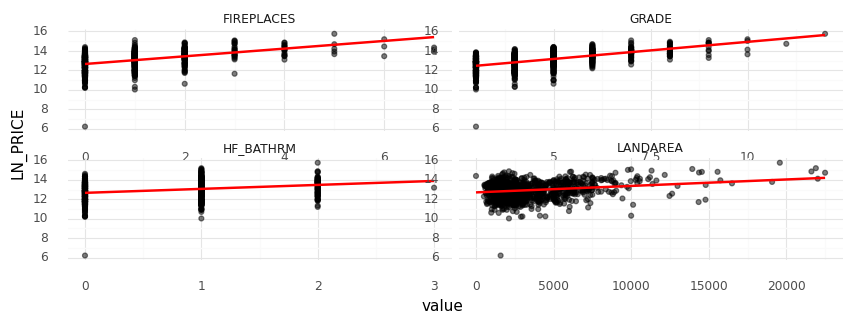

<ggplot: (8778121421475)>

In [11]:
D = xtr_sub.copy()
D['LN_PRICE'] = ytr_sub

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [12]:
#run it through a training pipeline

In [13]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["HF_BATHRM","FIREPLACES","LANDAREA","GRADE"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(xtr,ytr)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['HF_BATHRM',
                                                                          'FIREPLACES',
                                                                          'LANDAREA',
                                                                          'GRADE'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor(max_depth=5)],
                 

In [14]:
search.best_score_

-0.4556047724957759

In [15]:
search.best_params_

{'model': DecisionTreeRegressor(max_depth=5), 'model__max_depth': 5}

The ideal modell is a decision tree regressor based on this variable

### Test Performance

In [31]:
pred_y = search.predict(xts)

In [32]:
m.mean_squared_error(yts,pred_y)

0.44750434156711566

In [33]:
m.r2_score(yts,pred_y)

0.3948546520037445

The ideal model is a decision tree regressor, based on a model where land area, grade, half baths, and fireplaces are used to predict the log of price; this model has a MSE of 0.448, which is decent, and an r^2 of 0.395 which is fairly high for this kind of model